# Description:
## Overview
There are 3 known types of lncRNAs regarding their mechanism of action:
-  (A) For some lncRNA loci, the act of transcription itself plays a role in mediating the function of the lncRNA, for example by affecting the underlying chromatin structure of the locus. In this context, the RNA product itself and its sequence are inconsequential. 
- (B) By contrast, other lncRNAs act in the vicinity of their site of transcription, recruiting or diverting specific factors, which may recognize the RNA in sequence-specific or nonspecific ways.
- (C) Other lncRNAs leave their site of transcription and act elsewhere, typically in a sequence- or structure-dependent manner, and via interactions with protein and other RNA factors.



![](http://dev.biologists.org/content/develop/143/21/3882/F2.medium.gif)

(Perry RB, Ulitsky I. The functions of long noncoding RNAs in development and stem cells. Development. 2016 Nov 1;143(21):3882-3894.)

## Idea
Idea is pretty simple - make a classifier that will be able to detect patterns related to formation of spatial structure and active domains, e.g. type C and partually B.

## Data 
For the project I've used dataset of chimp orthologus/syntenic transcripts for human reference lncRNAs, obtained by us earlier using whole genome alignments and set of advanced and computationally expensive techniques (data avaliable on http://loris.amu.edu.pl:3380). Data has been dividet into 2 classes using transcript-transcript identity treshold of 0.15.


### Dependencies

In [0]:
import io
import pandas as pd
import numpy as np
from google.colab import drive

from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split

from sklearn import datasets
from sklearn.externals import joblib
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.linear_model import LogisticRegression

import seaborn as sns

In [0]:
def get_metrics(y_test, y_predicted):
    accuracy = accuracy_score(y_test, y_predicted)
    precision = precision_score(y_test, y_predicted, average='weighted')
    recall = recall_score(y_test, y_predicted, average='weighted')
    f1 = f1_score(y_test, y_predicted, average='weighted')
    return accuracy, precision, recall, f1

In [0]:
!pip install -q tf-nightly-gpu-2.0-preview

In [0]:
%load_ext tensorboard.notebook

In [0]:
import tensorflow as tf
import datetime

print(tf.__version__)
# Clear any logs from previous runs
!rm -rf ./logs/


2.0.0-dev20190414


### Loading of preprocessed data

In [0]:
drive.mount('/content/gdrive')
df=pd.read_csv('./gdrive/My Drive/Colab/Data/Chimp_new.csv')
print(df.head(5))
print(df.shape)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
       Transcript  exonID  locusID  \
0  MSTRG.11448.14    0.00     0.00   
1  MSTRG.11448.15    0.00     0.00   
2    MSTRG.4613.1    0.00     0.00   
3    MSTRG.8499.1    0.00     0.00   
4   MSTRG.10696.1    0.03     0.26   

                                            sequence  
0  TTTAAAACCCAATTTTTGTTCTCAACTTGAAAAGGGAACACTTTTT...  
1  TTTAAAACCCAATTTTTGTTCTCAACTTGAAAAGGGAACACTTTTT...  
2  CAGCTAATCATTTCCAAAGGTTAGTATCTCCCTGCTGACCTCTTCT...  
3  TGGGAGGATCACTTGAGGCCAGGAGTTCAAGGCAGCAGTGAGCTAT...  
4  CTTCGGTTGAAATGATTGCATGTTTTTGTCCTTCATTCTTTTGAAA...  
(78514, 4)


In [0]:
# selection of treshold - 15% of sequence similarity between transcripts
df['classification'] = np.where(df['exonID'] > 0.15, '1', '0')
print(df.groupby('classification')['Transcript'].nunique())

classification
0    71470
1     7044
Name: Transcript, dtype: int64


In [0]:
# function to convert sequence strings into k-mer words
def getKmers(sequence, size=3):
    return [sequence[x:x+size].lower() for x in range(len(sequence) - size + 1)]
  
df['words'] = df.apply(lambda x: getKmers(x['sequence']), axis=1)
df.drop(['sequence', 'exonID', 'locusID','Transcript'], axis=1, inplace=True)
df.head(5)

classification                                              words
0              0  [ttt, tta, taa, aaa, aaa, aac, acc, ccc, cca, ...
1              0  [ttt, tta, taa, aaa, aaa, aac, acc, ccc, cca, ...
2              0  [cag, agc, gct, cta, taa, aat, atc, tca, cat, ...
3              0  [tgg, ggg, gga, gag, agg, gga, gat, atc, tca, ...
4              0  [ctt, ttc, tcg, cgg, ggt, gtt, ttg, tga, gaa, ...

In [0]:
#dividing data lables
df_texts = list(df['words'])
for item in range(len(df_texts)):
    df_texts[item] = ' '.join(df_texts[item])
y_h = df.iloc[:, 0].values
y_h = y_h.astype(int)

#class weights
class_weights = class_weight.compute_class_weight(
               'balanced',
                np.unique(y_h), 
                y_h)

#Tain / test split
X_train, X_test, y_train, y_test = train_test_split(df_texts, y_h, test_size=0.15, random_state=1000)



In [0]:
# Count vectorization and  transformation a count matrix to a normalized tf representation
vectorizer = CountVectorizer(ngram_range=(8,8))
vectorizer.fit(X_train)

X_train = vectorizer.transform(X_train)
X_test = vectorizer.transform(X_test)
X_train


tf_transformer = TfidfTransformer(use_idf=False).fit(X_train)

X_train  = tf_transformer.transform(X_train)
X_test  = tf_transformer.transform(X_test)


print("training shape = %s \ntest shape = %s \n" % (X_train.shape, X_test.shape))

class_dict = { 0 : class_weights[0], 1 : class_weights[1]}
print(class_dict)

training shape = (66736, 1043135) 
test shape = (11778, 1043135) 

{0: 0.5492794179375962, 1: 5.573111868256673}


### Baseline model

In [0]:
# LogisticRegression 
clf = LogisticRegression(class_weight="balanced")
    
clf.fit(X_train, y_train)
y_pred_lr = clf.predict(X_test)


print("Confusion matrix\n")
print(pd.crosstab(pd.Series(y_test, name='Actual'), pd.Series(y_pred_lr, name='Predicted')))

accuracy, precision, recall, f1 = get_metrics(y_test, y_pred_lr)
print("accuracy = %.3f \nprecision = %.3f \nrecall = %.3f \nf1 = %.3f" % (accuracy, precision, recall, f1))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Confusion matrix

Predicted      0    1
Actual               
0          10512  129
1            490  647
accuracy = 0.947 
precision = 0.944 
recall = 0.947 
f1 = 0.943


### Keras model

In [0]:
# Simple model
input_dim = X_train.shape[1]  # Number of features
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(120, input_dim=input_dim, activation='relu')) #120 95
model.add(tf.keras.layers.Dropout(rate=0.8))
model.add(tf.keras.layers.Dense(80, activation='relu')) #80
model.add(tf.keras.layers.Dropout(rate=0.7))
model.add(tf.keras.layers.Dense(60, activation='relu'))
model.add(tf.keras.layers.Dropout(rate=0.7))
model.add(tf.keras.layers.Dense(30, activation='relu'))
model.add(tf.keras.layers.Dropout(rate=0.7))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
               optimizer='adam', 
               metrics=['accuracy'])
model.summary()

W0412 15:02:22.177155 140214428608384 nn_ops.py:4202] Large dropout rate: 0.8 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.
W0412 15:02:22.229099 140214428608384 nn_ops.py:4202] Large dropout rate: 0.7 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.
W0412 15:02:22.271741 140214428608384 nn_ops.py:4202] Large dropout rate: 0.7 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.
W0412 15:02:22.314646 140214428608384 nn_ops.py:4202] Large dropout rate: 0.7 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 120)               125176320 
_________________________________________________________________
dropout (Dropout)            (None, 120)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 80)                9680      
_________________________________________________________________
dropout_1 (Dropout)          (None, 80)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 60)                4860      
_________________________________________________________________
dropout_2 (Dropout)          (None, 60)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 30)                1

In [0]:
#Tensorboard logging
log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

#Early stopping
eas = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.001, patience=4, verbose=0,
                              mode='auto', baseline=None, restore_best_weights=False)


# Keep only a single checkpoint, the best over val loss.
filepath = "./gdrive/My Drive/Colab/Data/Chimp_3_8_8_balanced_last.hdf5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss',
                                             verbose=0, save_best_only=True, save_weights_only=True, mode='auto')



model.fit(X_train, y_train,
                     class_weight = class_dict,
                     epochs=30,
                     verbose=True,
                     validation_split=0.20,
                     #validation_data=(X_val, y_val),
                     batch_size=32, callbacks=[tensorboard_callback, eas, checkpoint])

Train on 53388 samples, validate on 13348 samples
Epoch 1/30
53388/53388 [==============================] - 580s 11ms/sample - loss: 0.6987 - accuracy: 0.4599 - val_loss: 0.6927 - val_accuracy: 0.0907
Epoch 2/30
53388/53388 [==============================] - 579s 11ms/sample - loss: 0.6901 - accuracy: 0.5062 - val_loss: 0.6926 - val_accuracy: 0.9105
Epoch 3/30
53388/53388 [==============================] - 581s 11ms/sample - loss: 0.6552 - accuracy: 0.7352 - val_loss: 0.6581 - val_accuracy: 0.9270
Epoch 4/30
53388/53388 [==============================] - 578s 11ms/sample - loss: 0.5224 - accuracy: 0.8881 - val_loss: 0.6072 - val_accuracy: 0.9367
Epoch 5/30
53388/53388 [==============================] - 580s 11ms/sample - loss: 0.4594 - accuracy: 0.9245 - val_loss: 0.5855 - val_accuracy: 0.9410
Epoch 6/30
53388/53388 [==============================] - 572s 11ms/sample - loss: 0.4323 - accuracy: 0.9385 - val_loss: 0.5677 - val_accuracy: 0.9434
Epoch 7/30
53388/53388 [====================

In [0]:
%tensorboard --logdir logs/fit

### Evaluation and metrics

In [0]:
# Evaluation on the test set
score = model.evaluate(X_test, y_test, verbose=3)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

y_pred = model.predict_classes(X_test)
pred = y_pred.reshape((-1))


act = y_test.reshape((-1, 1))
act = act.reshape((-1))
print(pd.crosstab(act, pred, rownames=['Real'], colnames=['Predicted'], margins=True))

accuracy, precision, recall, f1 = get_metrics(act, pred)
print("accuracy = %.3f \nprecision = %.3f \nrecall = %.3f \nf1 = %.3f" % (accuracy, precision, recall, f1))

Test loss: 0.2483206835535391
Test accuracy: 0.9441331
Predicted      0    1    All
Real                        
0          10606   35  10641
1            623  514   1137
All        11229  549  11778
accuracy = 0.944 
precision = 0.944 
recall = 0.944 
f1 = 0.935


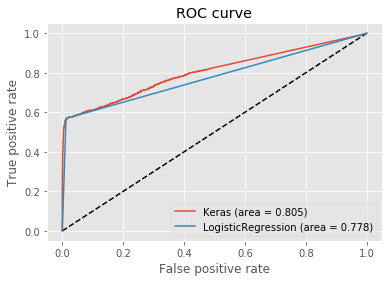

In [0]:
# ROC and AUC 
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import matplotlib.pyplot as plt

plt.style.use('ggplot')

y_pred_keras = model.predict(X_test).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_keras)
fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_test, y_pred_lr)


auc_keras = auc(fpr_keras, tpr_keras)
auc_lr = auc(fpr_lr, tpr_lr)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))

plt.plot(fpr_lr, tpr_lr, label='LogisticRegression (area = {:.3f})'.format(auc_lr))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()


In [0]:
# Saving the results
model.save('./gdrive/My Drive/Colab/Data/Chimp388015095_2.h5')
joblib.dump(vectorizer, './gdrive/My Drive/Colab/Data/vectorizer_chimp2.joblib')
joblib.dump(tf_transformer, './gdrive/My Drive/Colab/Data/transformer_chimp2.joblib')

['./gdrive/My Drive/Colab/Data/transformer_chimp2.joblib']

In [0]:
#load data

### Loading of my best model

In [0]:
# Vectorizer + transformer
vectorizer = joblib.load('./gdrive/My Drive/Colab/Data/vectorizer_chimp.joblib')
tf_transformer = joblib.load('./gdrive/My Drive/Colab/Data/transformer_chimp.joblib')

In [0]:
X_train = vectorizer.transform(X_train)
X_test = vectorizer.transform(X_test)
X_train

X_train  = tf_transformer.transform(X_train)
X_test  = tf_transformer.transform(X_test)


print("training shape = %s \ntest shape = %s \n" % (X_train.shape, X_test.shape))

class_dict = { 0 : class_weights[0], 1 : class_weights[1]}
print(class_dict)

training shape = (66736, 1043135) 
test shape = (11778, 1043135) 

{0: 0.5492794179375962, 1: 5.573111868256673}


In [0]:
from tensorflow.keras.models import load_model
model = load_model('./gdrive/My Drive/Colab/Data/Chimp388015095.h5')
model.summary()

W0414 11:01:41.504930 139664612493184 nn_ops.py:4202] Large dropout rate: 0.8 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.
W0414 11:01:41.562659 139664612493184 nn_ops.py:4202] Large dropout rate: 0.8 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 120)               125176320 
_________________________________________________________________
dropout (Dropout)            (None, 120)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 60)                7260      
_________________________________________________________________
dropout_1 (Dropout)          (None, 60)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 30)                1830      
_________________________________________________________________
dropout_2 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                3

In [0]:
# Evaluation on the test set
score = model.evaluate(X_test, y_test, verbose=3)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

y_pred = model.predict_classes(X_test)
pred = y_pred.reshape((-1))


act = y_test.reshape((-1, 1))
act = act.reshape((-1))
print(pd.crosstab(act, pred, rownames=['Real'], colnames=['Predicted'], margins=True))

accuracy, precision, recall, f1 = get_metrics(act, pred)
print("accuracy = %.3f \nprecision = %.3f \nrecall = %.3f \nf1 = %.3f" % (accuracy, precision, recall, f1))

Test loss: 0.2988843046803085
Test accuracy: 0.9515198
Predicted      0    1    All
Real                        
0          10558   83  10641
1            488  649   1137
All        11046  732  11778
accuracy = 0.952 
precision = 0.949 
recall = 0.952 
f1 = 0.947


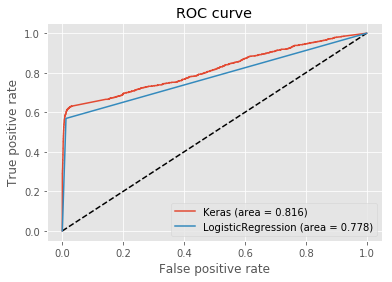

In [0]:
# ROC and AUC 
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import matplotlib.pyplot as plt

plt.style.use('ggplot')

y_pred_keras = model.predict(X_test).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_keras)
fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_test, y_pred_lr)


auc_keras = auc(fpr_keras, tpr_keras)
auc_lr = auc(fpr_lr, tpr_lr)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))

plt.plot(fpr_lr, tpr_lr, label='LogisticRegression (area = {:.3f})'.format(auc_lr))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

### making of predictions

In [0]:
# Two sequence to test
seq1 = "GGCCAAGTCTGTTATGTTCACCTGAAAAAGTCTTAGCAGAGAATTTTTGCATTCCCACCCAAAAGCCCTCTCAGCCACTCAAATGCCTATCTTCTCCAGTCTACAAGTTACATGTTCCCACCCAGCATTACAGTTCTTGAACATGTTATTTCTCCACTTACTGGTTTAAGTTGGTTTTAGTCACTGGATAAGTATTATAATAGAGCTACTTAGCTGTGGTTTTAATACCCTTCTGTTAACAATTTGCAGGCAAATTAATGGCCTTTTCTAACATAGTTCAACCCACCAAAGACCTCGACACCATCGTTACCTTGAAACCGATTATGGATCATGCCCACAAGGATCCAAGCTACTGGCTGCATCGAGGCAAGTCCTCATTACTAATAAAAATCAGGTGAGGCTGACACTTCTCTTGACCTTAGGATAATAGCGCTTTGTTGTCTCTCCTGCCACAGGAAGGCTCCATGGTTGTCCTACTTTAAGCCTTCGGTGCCTTTAGTGAGGGGTACCTGAAAAATCTTAAAAAAAGGCTTAGCGCCCACCTCACCCCTCCACCCCCACGCCAACACAGTTTGCTCACATGCCAGTTACTCCAGCATAAAGCTGAAATCTATTCAATACTATTGTCCCATAACTGATCTGACTTTGTATGTAAATACAGAAAAAGCTTGTTCACCTGTTTTCCTCATTTTGTCCACTGGTGAATTCAACTGGAAGCTCCTTCTATAGTCTGAAGAATACCATCTGAAAGAACTAGTGGTTCCCAATCCCCACATTTAAAATGGAATGTTTGGTTTATTTAAAGTAAATAGGCTATTTTTTCTTACTGGGTCTGGCTTCTCTGGCCCTTCGCATACGTGTGTCTGCTGAGTGTTCCTGCATGTAAGAATTAAGACCAAGGGAGGGGAGAGAGAAACCCACACATAAACAATGCACTAAAGATCACTGAACTGTTTAAACATTTCCACTTGCCAGTTTAATTTCTTGAAGACTGTTGCTTGTTTGGAATGTTTCTTGTCACTGATTTTAAGGTTGCATCTGGAAAAGACTAAAGGCTTCAGTCCCCTCCCACCACCAGAAATGAACAAAAAGCATTTTACCTAAAAATACACCAGCAAAATGTACTCAGCTTCAATCACAAATACGACTGCT"

seq2 ="AGGCTGAGGCAGGAGAATTGCTTGAACCCGGGAGGCGGAGGTTGCAGTGAGCTGAGATCATGCCACTGCACTCCAGCCTGGGTGACAGAGGGAGACTCCGTCTCAAAAAAAAAAAAAAAAAAAAAAAAAAAGAAAAGAAAAGAGAAAAGAAGTGGCAAAACCAAGGATCTAAGGAGGAGCTAATGGAAAAAAGGCAAATAAACACAGACCTATAAAAAGATACTCATGGTAGACACAAGTATGATGTACTACAGAAAAGGGCAAGGACAAAGAAATATTGACACTGGTTTTTAAGAATTCCCAAGAGTTAAGGGGAAGAACTCTTTCCAGGAAAGGAAACTATACACATGACTTCAGTGCAGCAGAAAAGTAACTAATTACAGATACAAGTAAATTTCCAACCAAACAAAGCAGGTAACTGGAGCCTCCCCCTCTGGAAAGCTATGCAAATAAGAGGTCACCAAATGGCCCAAGAATACTCGTTTTGTCAGTAAATTGAATGTTCCAACTCTTGTGCTAAACCCAAGAGAAAAATGTATTTAAATATTTAAACTGCCTTCCTTCAGTTTATGGTCTTGTAATGGGAACAGGTGATATCAGTACACTGTGATAAGAGCTTTGATCAAATTCTGCACAAGAGCTGCACAAGGGTGGCAAGAAAAGGGTAACCTTGCTAGGATGGCTTCTTGGAGGAATCTCTTCCTGAGTCAAGTCCTAAAGAATAACTGAACAGGAGCTATTCAAGTGAAAGAAAAGGAGAGAGAATGTTCACACCAAGAGCCAATGAGGTAGATACAACCTTTTCCCTTGATCTCATCAGTACCATGAATATCACTCTTGGGATTGATTTAATTGCCAACAATATCTTTATAAATATAATCTTAGTTTCCAGGTTCTAAAAGGATGTAGGATAGAGCAAGTAATAAGACAAGCTGTGGCCAGGAGTGGTGGCTCACACCTGTAATCCTAGCACTCTGGAAGGCCGATGCGACGGATCACCTGAGGTCAGGGTATTACCAGCCTGGCCAACATGGCGAAACCCCATCTTTACTGAAAATACAAAAATTAGGCCGGGTTTGGTGGCTTACACCTGTAATCCCAGCACTTTGGGAGGCCGAGGAGGGCAGATCACGAGGTCAGGAGTTCGAGACCAGCCTGACCAACATGGTGAAACCCCGTCTCTCCTAAAAATACAAAAATTAGCCGGGCATGGTGGCACATGCCTGTGGTCCCAGATACTCAGAAGGCTGAGACAGGAGGAATCGCTTGAACTCGGGAGGTGGAGGTTGCAGTGAGCCGAGATTGAGCCACTGCACTCCGGCTTGGGTGACAGAGCAAGACTCCATCTCAAAAAAAAAAAAAAAAAAAAATTAGCTGGGCGTGGTGGCACATGCCTGTAATCTCAGCTACTTGGGAGGCCAAGACATGAGAATCACCTGAACCCGGGAGGCGGAGGTTGCAGTGAGCTGATATAGTGCCACTGCACTCCAGTCTGGGTAACAGAGCGAGACCCTGTCTCAAAAAATAATAATAATAATAAGACAAGTTGAGGCTGGGTACAGTGGCTAACGTCTGTAACCCCAGCACTTTGGGAGGCCGAGGCAGGCAGATCACTTAAGACTTGAGGTCAGGAGTTCGAGACCAGCCTGGCCAACAAGGCGAAACCCCCTCTCTACTAAAAATACAAAAATTAGCTGGACATGGTGGTGCACACCTTAATCCCAGCTACTCGGGTGGCTGAGGCAGGAGAATCGCTTGAACCCAGGAGGCAGAGGTTGCAGTGAGCTGAGATCATGCCACTGCACTCCAGCCTGGGATACAGAGTGAGGCTCCATCTCAAAAAAAAAAAAAAAGACAAGTTGTGAGTAAAGCCAGTACACCAACACTGTCTTTCCTAATACTTCTGACCCAGGAAGAATTTTATAGTCTAGTTTAAGTTGGTTTTGGAAACCACTCTTTTCTGCTAAAACAAAATCAAAACTTCAATCTGAGTGTCAAACCACAAGCTACCAGGGCAATGCTCTTTATAATCAAATTTCCAAGGGATCAAGCAAGCAAGTCTGGACTTGACAAGAGGAACCTGGTGGCCTGCTGCCACCAGGGTCTAAGGCAGGTTTCCTGGGCTTAATGCCCAATGACCTGTTGGCCTCTCGCAGATTACCCAGCACGCATGAGAAGGCTCTGAAATTACACCTGGGGTGAGAGCTTGAACAACACCCTGGCTTAAGGGGAAAAGGAAGAAGAAACCTGAATCTTGCTTCTCCCTTTCTTTTGCTGGTGAAACTGAACACCGAAAAGGCTGAGGCTTGGGGAACAGGGATGAAAGATGGAGGAGATCTGCAAAGAACAAGAGCTCCCTAGGGAAGAATGAAGGTGCCACATAGATGTTTTTCTCTAGGACAGAAAATCATCCTCGGCCAGCTCTTGACTTCCTCATCTTCTGCTTGATACAACTGCTTTCCAGCCTAGCTGTGCGTGAACAGATTCCAGACTCTGAGCTTGTCAGGAACTGCCTATCTGGACCTTTGGCAGCATTCAGAAACCCTCATGTTATCTTTTTTATTTTTATTTTTTTGAGATAGAGTTTCATTCTTGTCACCCAGGCTGGGG"

def getKmers(sequence, size=3):
    return [sequence[x:x+size].lower() for x in range(len(sequence) - size + 1)]
  
testing = getKmers(seq1, size=3)
test = tf_transformer.transform(vectorizer.transform([" ".join(testing)]))
y_proba = model.predict(test)
print("Predicted probability ", y_proba)

Predicted probability  [[0.9999528]]


### Addition. Classes vs probabilities

In [0]:
# Addition
y_proba = model.predict(X_test)
true_vs_prob = pd.DataFrame(
    {'True': y_test,
     'Predicted':  y_proba.ravel(),
    })
true_vs_prob.head(3)

True  Predicted
0     0   0.214917
1     1   0.838467
2     0   0.214542

True
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
Name: Predicted, dtype: object

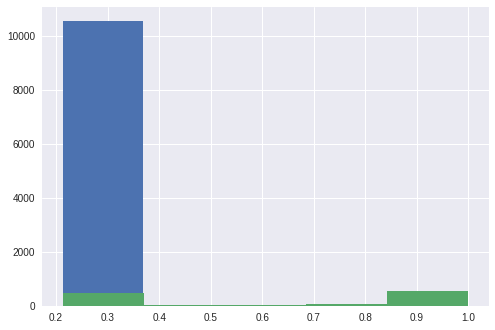

In [0]:
true_vs_prob.groupby('True')['Predicted'].hist(bins=5)

True
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
Name: Predicted, dtype: object

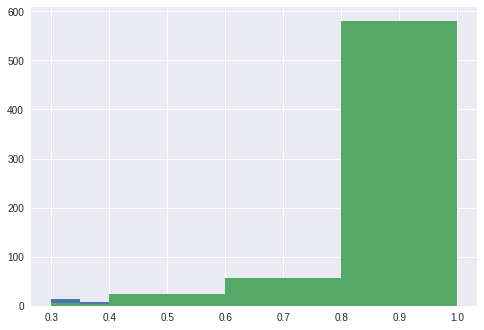

In [0]:
true_vs_prob.groupby('True')['Predicted'].hist(bins = [0.3, 0.35, 0.4, 0.6, 0.8, 1])

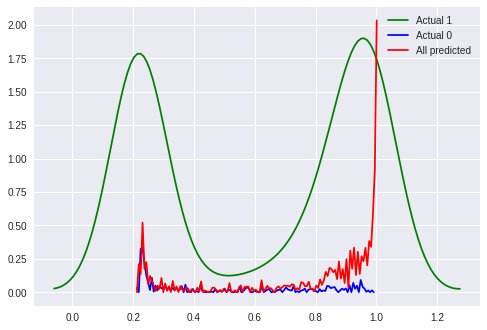

In [0]:
mask = true_vs_prob['True'] == 1
sns.kdeplot(true_vs_prob.Predicted[mask], color="g", label="Actual 1")
sns.kdeplot(true_vs_prob.Predicted[-mask], color="b", label="Actual 0")
sns.kdeplot(true_vs_prob.Predicted, color="r", label="All predicted")

### Flask
Next we pack the model with flask. For production we can add gevent WSGIServer

In [0]:
####Dependencies
#1) Python 3
#2) flask, numpy, tensorflow 2.0, sklearn, joblib

#http://localhost:5000/predict?text=

import os
from flask import jsonify
from flask import request
from flask import Flask
import numpy as np


from sklearn.externals import joblib
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer


import tensorflow.keras as keras
import tensorflow as tf

np.random.seed(1337)


#star Flask application
app = Flask(__name__)

#Load model

keras_model_loaded = keras.models.load_model('./Chimp388015095.h5')
print('Model loaded...')


#load vect + transformer
with open('./vectorizer_chimp.joblib', 'rb') as file_vect:
    vectorizer = joblib.load(file_vect)
with open('./transformer_chimp.joblib', 'rb') as file_trans:
    tf_transformer = joblib.load(file_trans)

def getKmers(sequence, size):
    return [sequence[x:x+size].lower() for x in range(len(sequence) - size + 1)]

def preprocess_text(text):
    testing = getKmers(text, size=3)
    testing_processed = tf_transformer.transform(vectorizer.transform([" ".join(testing)]))
    return testing_processed


@app.route('/predict',methods=['GET','POST'])


def predict():
	text = request.args.get('text')
	x = preprocess_text(text)
	prob = keras_model_loaded.predict(x)
	y = int(np.round(prob))
	if y == 1:
		return jsonify({'prediction': "Conserved", 'proba': str(prob[0][0])})
	else:
		return jsonify({'prediction': "Not conserved", 'proba': str(prob[0][0])})


if __name__ == "__main__":
    # Run locally
    app.run(debug=False)

Simple web interface http://loris.amu.edu.pl:3380/json.php

In [0]:
#to kill VM
!kill -9 -1